# Per-residue feature values

We investigate the defined features per residue

- over all structures (boxplots/heatmaps)
- for example structures (in 3D)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nglview
from opencadd.databases.klifs import setup_remote

from kissim.encoding import Fingerprint, FingerprintGenerator

In [3]:
plt.style.use("seaborn")

In [4]:
HERE = Path(_dh[-1])  # noqa: F821
RESULTS = HERE / "../../results/all"

## Load fingerprints

In [5]:
fingerprint_generator = FingerprintGenerator.from_json(RESULTS / "fingerprints_clean.json")
print(f"Number of fingerprints: {len(fingerprint_generator.data)}")

Number of fingerprints: 4623


## Load structure metadata

In [6]:
REMOTE = setup_remote()

In [7]:
structure_klifs_ids = list(fingerprint_generator.data.keys())

In [8]:
structures = REMOTE.structures.all_structures()
structures = structures[structures["structure.klifs_id"].isin(structure_klifs_ids)]
structures = structures.set_index("structure.klifs_id")
structures.head()

,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.family,kinase.group,structure.pocket,ligand.expo_id,...,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath
structure.klifs_id,,,,,,,,,,,,,,,,,,,,,
10430,6buu,A,B,Human,1,AKT1,<NA>,<NA>,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,-,...,False,False,False,False,False,False,17.901100,59.594799,60.872501,<NA>
2544,3qkl,-,A,Human,1,AKT1,<NA>,<NA>,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,SMR,...,False,False,False,False,False,False,18.555599,60.174702,57.331100,<NA>
2546,3qkm,-,A,Human,1,AKT1,<NA>,<NA>,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,SM9,...,False,False,False,False,False,False,18.525400,58.479000,54.855202,<NA>
6762,3cqu,B,A,Human,1,AKT1,<NA>,<NA>,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,CQU,...,False,False,False,False,False,False,16.400400,52.805099,47.165001,<NA>
6763,3cqw,A,A,Human,1,AKT1,<NA>,<NA>,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,CQW,...,False,False,False,False,False,False,17.943501,58.283501,52.774200,<NA>


In [9]:
residue_to_color = (
    REMOTE.pockets.by_structure_klifs_id(12347)
    .set_index("residue.klifs_id")["residue.klifs_color"]
    .to_dict()
)

## Per-residue feature distributions

In [66]:
def continuous_features_per_residue_ix_boxplot(features, feature_type, residue_to_color, ax):
    features = features.reset_index().drop("structure_klifs_id", axis=1).melt(id_vars="residue_ix")
    flierprops = dict(markersize=0.5, linestyle="none")
    sns.boxplot(
        x="residue_ix",
        y="value",
        data=features,
        palette=residue_to_color,
        ax=ax,
        linewidth=0.5,
        flierprops=flierprops,
    )
    ax.set_ylabel(feature_type, fontsize=9)
    ax.set_xlabel("")
    ax.tick_params(labelsize=7)
    ax.tick_params(axis="x", rotation=90)

In [38]:
def discrete_features_per_residue_ix_heatmap(features, feature_type, ax):
    structure_position_matrix = features.unstack(level=1)
    counts = (
        pd.concat(
            [
                features.dropna().value_counts()
                for residue_ix, features in structure_position_matrix.items()
            ],
            axis=1,
        )
        .fillna(0)
        .astype("int32")
    )
    sns.heatmap(counts, cmap="Blues", ax=ax)
    ax.set_ylabel(feature_type)

### Physicochemical features

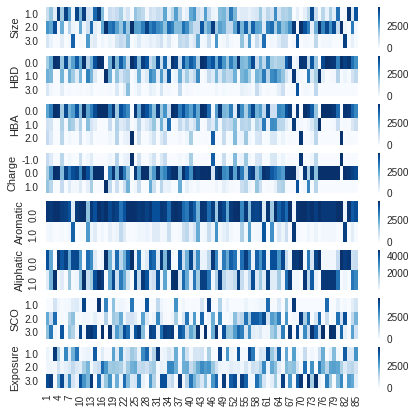

In [45]:
feature_type_dict = {
    "size": "Size",
    "hbd": "HBD",
    "hba": "HBA",
    "charge": "Charge",
    "aromatic": "Aromatic",
    "aliphatic": "Aliphatic",
    "sco": "SCO",
    "exposure": "Exposure",
}

features_p = fingerprint_generator.physicochemical_exploded().drop(
    ["sco.vertex_angle", "exposure.ratio"], axis=1
)
fig, axes = plt.subplots(8, 1, figsize=(7, 7), sharex=True)
for i, (feature_type, features) in enumerate(features_p.items()):
    discrete_features_per_residue_ix_heatmap(features, feature_type_dict[feature_type], ax=axes[i])
fig.savefig("feature_distribution_per_residue_physicochemical.pdf")

### Distance features

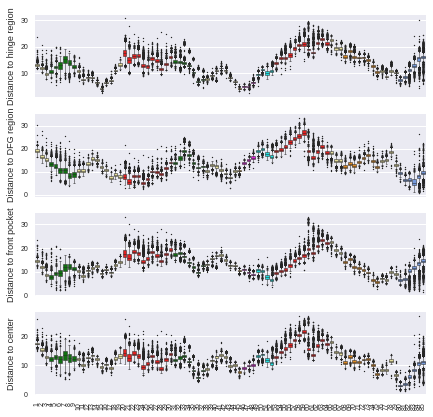

In [67]:
feature_type_dict = {
    "center": "Distance to center",
    "hinge_region": "Distance to hinge region",
    "dfg_region": "Distance to DFG region",
    "front_pocket": "Distance to front pocket",
}

features_d = fingerprint_generator.distances_exploded()
fig, axes = plt.subplots(4, 1, figsize=(7, 7), sharex=True)
for i, (feature_type, features) in enumerate(features_d.items()):
    continuous_features_per_residue_ix_boxplot(
        features, feature_type_dict[feature_type], residue_to_color, ax=axes[i]
    )
fig.savefig("feature_distribution_per_residue_distances.pdf")

## Select descriptors

In [16]:
def discrete_feature_vs_klifs_category_by_residue_ix(
    features, feature_type, residue_ix, structures, klifs_category
):

    features = features[feature_type]
    features_residue_ix = features[
        features.index.get_level_values("residue_ix").isin([residue_ix])
    ]
    features_residue_ix.index = features_residue_ix.index.droplevel("residue_ix")
    features_residue_ix.index.name = "structure.klifs_id"

    feature_residue_ix_vs_klifs_category = features_residue_ix.reset_index().merge(
        structures[[klifs_category]].reset_index(), how="left"
    )
    feature_residue_ix_vs_klifs_category.groupby(
        [feature_type, klifs_category]
    ).size().unstack().plot(kind="bar");

#### SCO(E24) vs. aC-helix conformation?

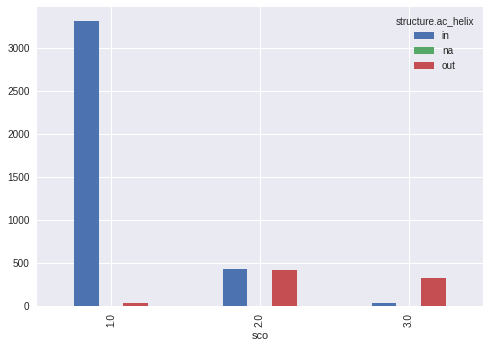

In [17]:
discrete_feature_vs_klifs_category_by_residue_ix(
    features_p, "sco", 24, structures, "structure.ac_helix"
)

## Example fingerprint in 3D

In [18]:
STRUCTURE_KLIFS_ID = 3835

In [19]:
discrete_feature_values_dict = {
    "size": [1.0, 2.0, 3.0],
    "hbd": [0.0, 1.0, 2.0, 3.0],
    "hba": [0.0, 1.0, 2.0],
    "charge": [-1.0, 0.0, 1.0],
    "aromatic": [0.0, 1.0],
    "aliphatic": [0.0, 1.0],
    "sco": [1.0, 2.0, 3.0],
    "exposure": [1.0, 2.0, 3.0],
}
viridis_colors = {
    2: ["darkslateblue", "yellow"],
    3: ["darkslateblue", "cadetblue", "yellow"],
    4: ["darkslateblue", "cadetblue", "limegreen", "yellow"],
}

In [20]:
example_fingerprint = Fingerprint.from_structure_klifs_id(3835)
example_features = example_fingerprint.physicochemical
example_features.index = example_fingerprint.residue_ids
example_features

,size,hbd,hba,charge,aromatic,aliphatic,sco,exposure
50,2.0,0.0,2.0,-1.0,0.0,0.0,3.0,3.0
51,1.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0
52,2.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0
53,1.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0
54,2.0,0.0,2.0,-1.0,0.0,0.0,NaN,3.0
...,...,...,...,...,...,...,...,...
194,2.0,0.0,2.0,-1.0,0.0,0.0,3.0,2.0
195,3.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0
196,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0
197,1.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0


### Side chain orientation

In [21]:
discrete_feature_values = discrete_feature_values_dict["sco"]
value_to_color = {
    value: color
    for value, color in zip(discrete_feature_values, viridis_colors[len(discrete_feature_values)])
}
value_to_color

{1.0: 'darkslateblue', 2.0: 'cadetblue', 3.0: 'yellow'}

In [23]:
color_scheme_list = []
for residue_id, value in example_features.iterrows():
    try:
        color = value_to_color[value["sco"]]
    except KeyError:
        color = "grey"
    color_scheme_list.append([color, str(residue_id)])

viewer = nglview.NGLWidget()
# viewer._remote_call("setSize", target="Widget", args=["1000px", "600px"])
text = REMOTE.coordinates.to_text(3835, "complex", "pdb")
viewer.add_component(text, ext="pdb")
viewer.clear_representations()
color_scheme = nglview.color._ColorScheme(color_scheme_list, label="scheme_regions")
viewer.add_representation("cartoon", selection="protein", component=0, color="grey")
selection = " or ".join([str(i) for i in example_fingerprint.residue_ids])
viewer.add_representation("ball+stick", selection=selection, color=color_scheme)
viewer  # .display(gui=True)

NGLWidget()

In [24]:
viewer.render_image(trim=True, transparent=True);

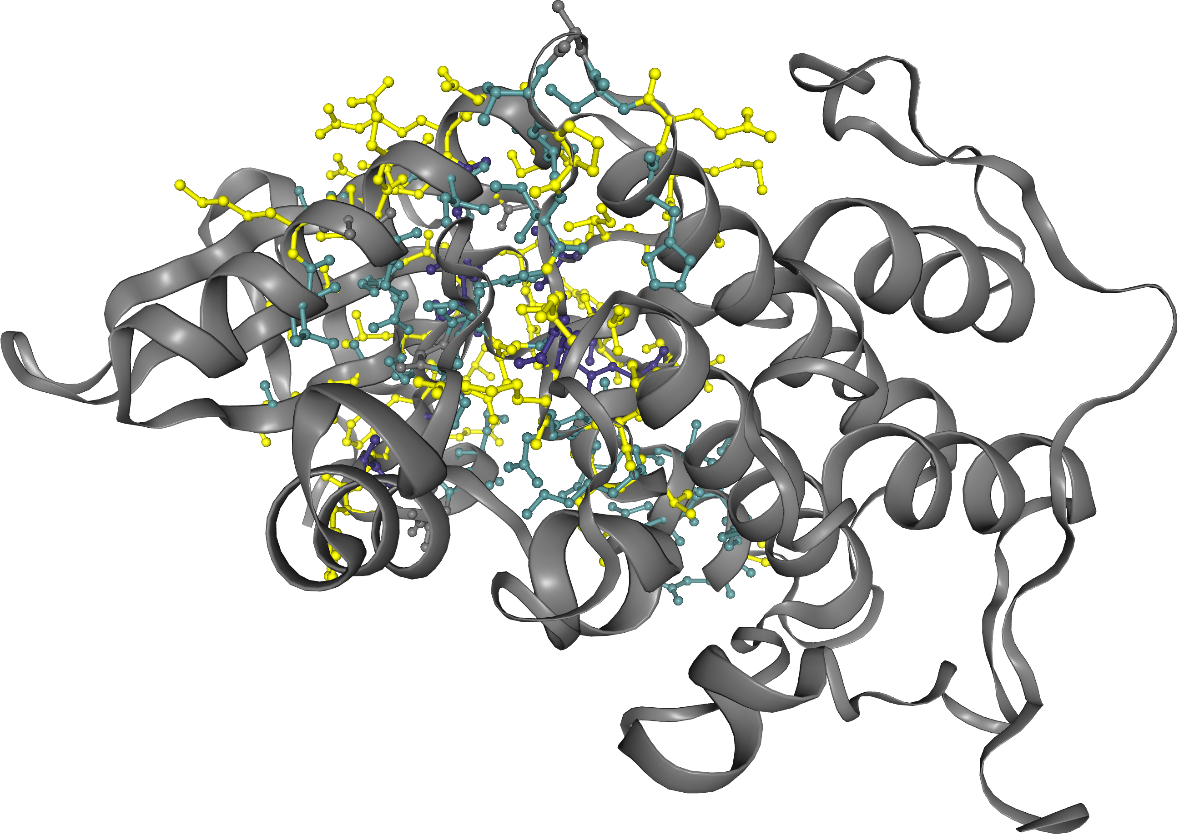

In [25]:
viewer._display_image()

### Solvent exposure

In [26]:
discrete_feature_values = discrete_feature_values_dict["exposure"]
value_to_color = {
    value: color
    for value, color in zip(discrete_feature_values, viridis_colors[len(discrete_feature_values)])
}
value_to_color

{1.0: 'darkslateblue', 2.0: 'cadetblue', 3.0: 'yellow'}

In [27]:
color_scheme_list = []
for residue_id, value in example_features.iterrows():
    try:
        color = value_to_color[value["exposure"]]
    except KeyError:
        color = "grey"
    color_scheme_list.append([color, str(residue_id)])

viewer = nglview.NGLWidget()
text = REMOTE.coordinates.to_text(3835, "complex", "pdb")
viewer.add_component(text, ext="pdb")
viewer.clear_representations()
color_scheme = nglview.color._ColorScheme(color_scheme_list, label="scheme_regions")
viewer.add_representation("cartoon", selection="protein", component=0, color=color_scheme)
selection = " or ".join([str(i) for i in example_fingerprint.residue_ids])
viewer.add_representation("ball+stick", selection=selection, color=color_scheme)
viewer.display(gui=True)

NGLWidget(gui_style='ngl')

In [28]:
viewer.render_image(trim=True, transparent=True);

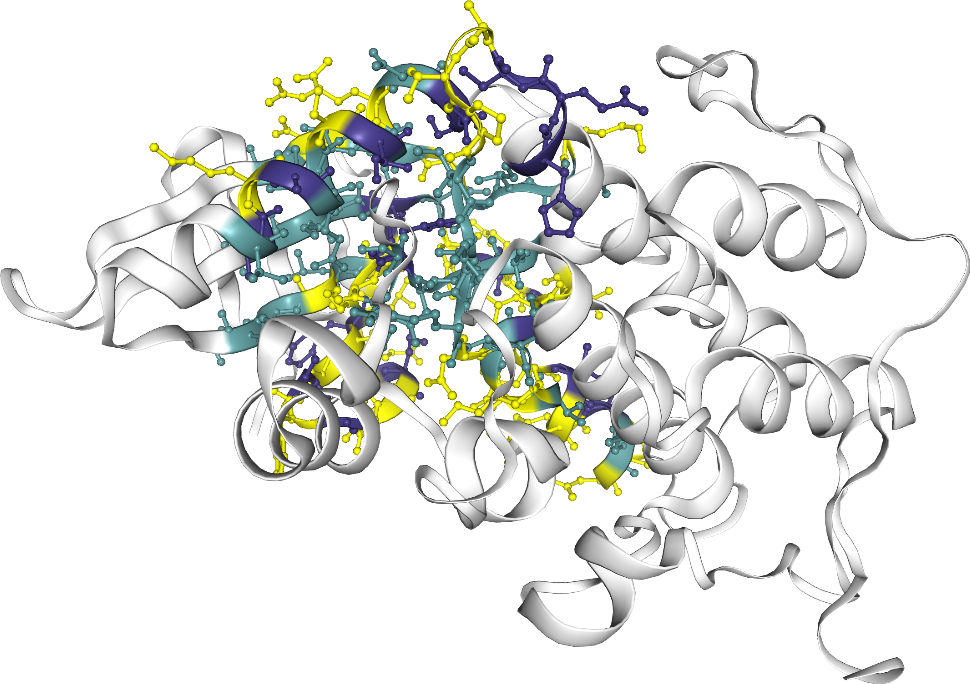

In [29]:
viewer._display_image()

### Use the `kissim.viewer` instead :)

In [30]:
from kissim.viewer import StructureViewer

In [31]:
viewer = StructureViewer.from_structure_klifs_id(3835)
viewer.show()

interactive(children=(Dropdown(description='Feature: ', options=('size', 'hbd', 'hba', 'charge', 'aromatic', '…